In [2]:
import numpy as np 
import pandas as pd 
import torch
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.signal import stft
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tokenized-data-eeg/tokenized_data.npy
/kaggle/input/eeg-signals-data/eeg_signals_raw_with_mean_std (4).pth


In [3]:
data = torch.load('/kaggle/input/eeg-signals-data/eeg_signals_raw_with_mean_std (4).pth', map_location='cpu')

In [34]:
data.keys()

dict_keys(['dataset', 'labels', 'images', 'means', 'stddevs'])

In [35]:
print(type(data['dataset']))
print(len(data['dataset']))

sample = data['dataset'][0]
print(type(sample))
print(sample.keys())

<class 'list'>
11965
<class 'dict'>
dict_keys(['eeg', 'image', 'label', 'subject'])


In [36]:
eeg_signal = np.array(sample['eeg'])
print(eeg_signal.shape)
#(128, 500) as mentioned in the readme

(128, 500)


In [37]:
raw_dataset=data['dataset']
eeg_signals=[segment['eeg'] for segment in raw_dataset]
lengths = [eeg.shape[1] for eeg in eeg_signals]
print(set(lengths))
#varying lengths: most of them lie near 500 with some outliers, will fix the length to 512

{512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 569, 570, 571, 572, 574, 575, 576, 577, 578, 579, 580, 581, 589, 590, 592, 593, 594, 596, 598, 1527, 602, 606, 607, 611, 618, 622, 633, 639, 641, 1044, 648, 669, 687, 698, 699, 710, 719, 727, 734, 751, 765, 827, 912, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511}


In [9]:
def fix_length(eeg_segment, target_length=512):
    channels, length=eeg_segment.shape
    if length>target_length:
        return eeg_segment[:, :target_length]
    elif length<target_length:
        pad_width = target_length - length
        pad = np.zeros((channels, pad_width))
        return np.concatenate([eeg_segment, pad], axis=1)
    else: 
        return eeg_segment

fixed_eeg_signals = [fix_length(eeg) for eeg in eeg_signals]

In [7]:
def bandpass_filter(data, lowcut=5, highcut=95, fs=1000, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = np.array([filtfilt(b, a, channel_data) for channel_data in data])
    return y

In [10]:
raw_dataset=data['dataset']
eeg_signals=[segment['eeg'] for segment in raw_dataset]

filtered_data=[]
for eeg in eeg_signals:
    filtered=bandpass_filter(eeg)
    fixed=fix_length(filtered)
    filtered_data.append(fixed)

filtered_data=np.array(filtered_data)
print(f"Filtered data shape: {filtered_data.shape}")

Filtered data shape: (11965, 128, 512)


In [ ]:
np.save('/kaggle/working/filtered_data.npy', filtered_data)

In [ ]:
!zip -r filtered_data.zip filtered_data.npy

In [ ]:
from IPython.display import FileLink
FileLink('filtered_data.zip')

In [ ]:
file_path = '/kaggle/input/filtered-data-eeg/filtered_data.npy'

filtered_data = np.load(file_path)

In [11]:
lengths = [eeg.shape[1] for eeg in filtered_data]
print(set(lengths))
#lengths fixed correctly as {512} is our unique output

{512}


In [12]:
means = np.mean(filtered_data, axis=(1, 2), keepdims=True)
stds = np.std(filtered_data, axis=(1, 2), keepdims=True)
normalized_data = (filtered_data - means) / stds

print(normalized_data.shape)

(11965, 128, 512)


In [ ]:
np.save('normalized_data.npy', normalized_data)

In [ ]:
normalized_data = np.load('normalized_data.npy')

In [13]:
channel_counts=[segment.shape[0] for segment in filtered_data]
print(set(channel_counts))
#128 channels per sample, no padding needed

{128}


In [14]:
tokenized_data=[]
for sample in normalized_data:
    tokens=sample.reshape(128, 128, 4)
    tokenized_data.append(tokens)

tokenized_data=np.array(tokenized_data)
print(tokenized_data.shape)
#temporal tokenization done correctly

(11965, 128, 128, 4)


In [ ]:
np.save('/kaggle/working/tokenized_data.npy', tokenized_data)

!zip -r tokenized_data.zip tokenized_data.npy

from IPython.display import FileLink
FileLink('tokenized_data.zip')

In [1]:
import numpy as np
file_path = '/kaggle/input/tokenized-data-eeg/tokenized_data.npy'

tokenized_data = np.load(file_path)

In [2]:
import os
import gc
import psutil

proj_matrix = np.random.randn(4, 1024).astype(np.float16)

batch_size = 200
num_samples = tokenized_data.shape[0]

saved_batches = set()
for f in os.listdir():
    if f.startswith("embedded_batch_") and f.endswith(".npz"):
        parts = f.split("_")
        saved_batches.add((int(parts[2]), int(parts[3].split(".")[0])))

for start_idx in range(600, num_samples, batch_size):
    end_idx = min(start_idx + batch_size, num_samples)
    
    if (start_idx, end_idx) in saved_batches:
        print(f"Skipping already saved batch {start_idx} to {end_idx}")
        continue

    try:
        batch = tokenized_data[start_idx:end_idx].astype(np.float16)
        batch_reshaped = batch.reshape(-1, 4)
        batch_embedded = np.dot(batch_reshaped, proj_matrix)
        batch_embedded = batch_embedded.reshape(end_idx - start_idx, 128, 128, 1024)
        np.savez_compressed(f"embedded_batch_{start_idx}_{end_idx}.npz", batch_embedded)

        print(f"Saved batch {start_idx} to {end_idx}")
        print(f"Available memory: {psutil.virtual_memory().available // (1024 ** 2)} MB")

        del batch, batch_reshaped, batch_embedded
        gc.collect()
    except Exception as e:
        print(f"Failed at batch {start_idx} to {end_idx}: {e}")
        break

print("Done saving embedded batches.")
#embedded 6 batches of 200 samples each


Saved batch 600 to 800
Available memory: 18411 MB
Saved batch 800 to 1000
Available memory: 18408 MB
Saved batch 1000 to 1200
Available memory: 18391 MB
Failed at batch 1200 to 1400: [Errno 28] No space left on device
Done saving embedded batches.


In [3]:
from IPython.display import FileLink

FileLink("embedded_batch_600_800.npz")

/kaggle/working/embedded_batch_600_800.npz

In [4]:
FileLink("embedded_batch_800_1000.npz")

/kaggle/working/embedded_batch_800_1000.npz

In [5]:
FileLink("embedded_batch_1000_1200.npz")

/kaggle/working/embedded_batch_1000_1200.npz

In [7]:
import os

files = os.listdir('.')
for f in files:
    if f.startswith('embedded_batch_') and not f.startswith('embedded_batch_800_1000'):
        try:
            os.remove(f)
            print(f"Deleted {f}")
        except Exception as e:
            print(f"Could not delete {f}: {e}")

In [5]:
import numpy as np

data = np.load('embedded_batch_800_1000.npz')
embedded_data = data['arr_0']
print(embedded_data.shape)
#shape as expected

(200, 128, 128, 1024)


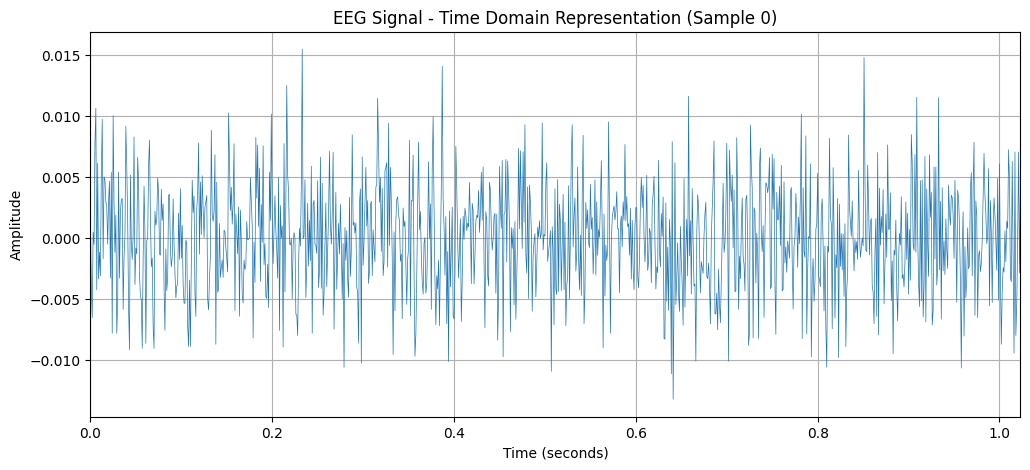

In [19]:
sample_signal = embedded_data[0, 0, 0, :]
n_samples = len(sample_signal)
time = np.arange(n_samples) / fs

plt.figure(figsize=(12, 5))
plt.plot(time, sample_signal, linewidth=0.5)
plt.xlim([time[0], time[-1]])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('EEG Signal - Time Domain Representation (Sample 0)')
plt.grid(True)
plt.show()


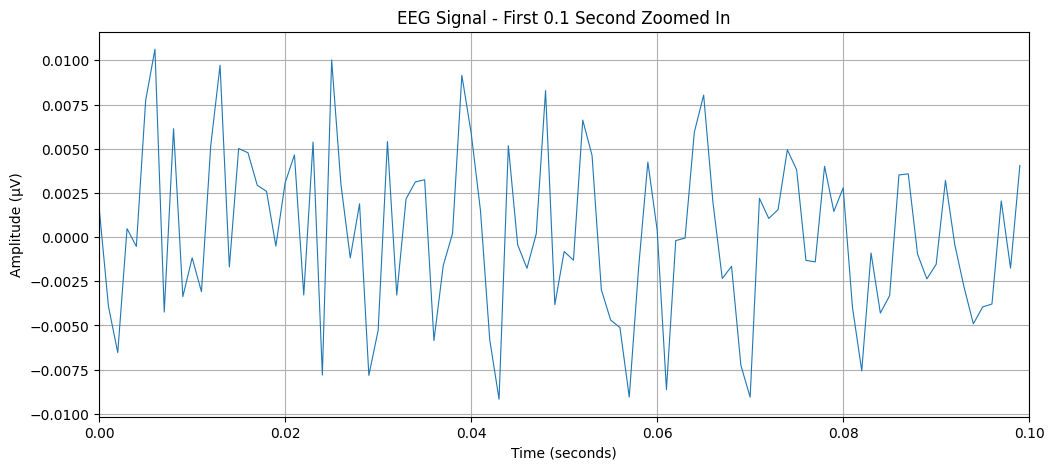

In [22]:
#zooming in for clearer visualisation
fs=1000.0
batch_index=0

eeg_signal=embedded_data[batch_index][0].flatten()
n_samples=len(eeg_signal)
time=np.arange(n_samples)/fs

plt.figure(figsize=(12, 5))
segment_length = 0.1
plt.plot(time[:int(segment_length * fs)], eeg_signal[:int(segment_length * fs)], linewidth=0.8)
plt.xlim(0, segment_length)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title(f'EEG Signal - First {segment_length} Second Zoomed In')
plt.grid(True)
plt.show()

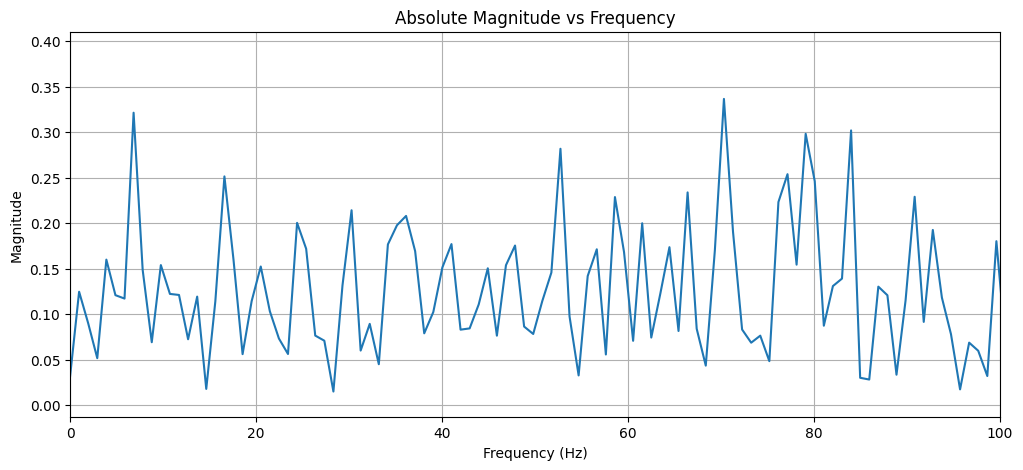

In [7]:
fs = 1000.0
signal = embedded_data[0, 0, 0, :]

n = len(signal)
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(n, d=1/fs)

half_n = n // 2
frequencies = frequencies[:half_n]
magnitude = np.abs(fft_result[:half_n])

plt.figure(figsize=(12, 5))
plt.plot(frequencies, magnitude)
plt.title('Absolute Magnitude vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 100)
plt.show()

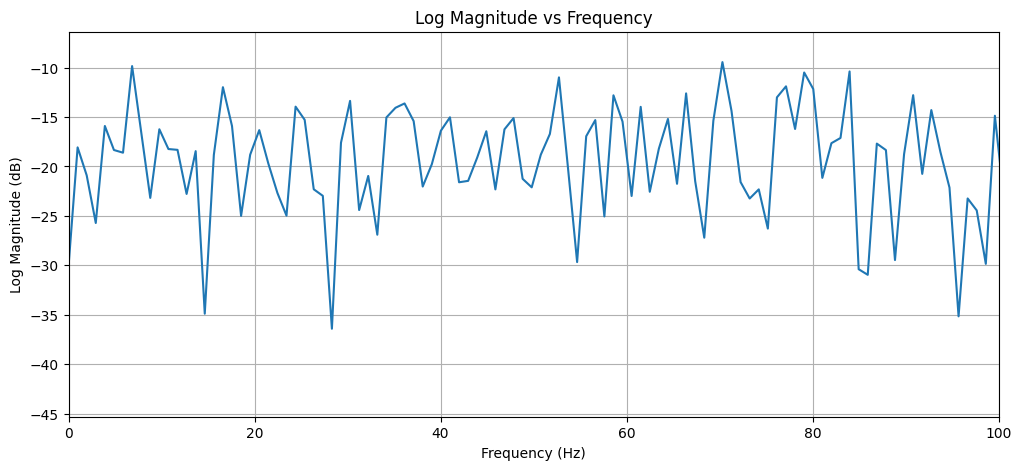

In [9]:
log_magnitude = 20 * np.log10(magnitude + 1e-10)

plt.figure(figsize=(12, 5))
plt.plot(frequencies, log_magnitude)
plt.title('Log Magnitude vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Magnitude (dB)')
plt.grid(True)
plt.xlim(0, 100)
plt.show()

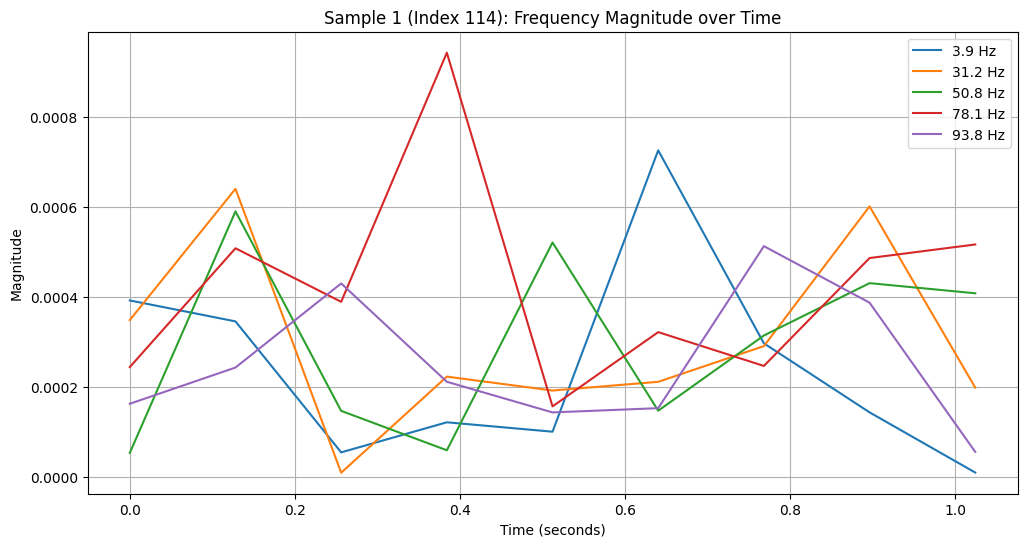

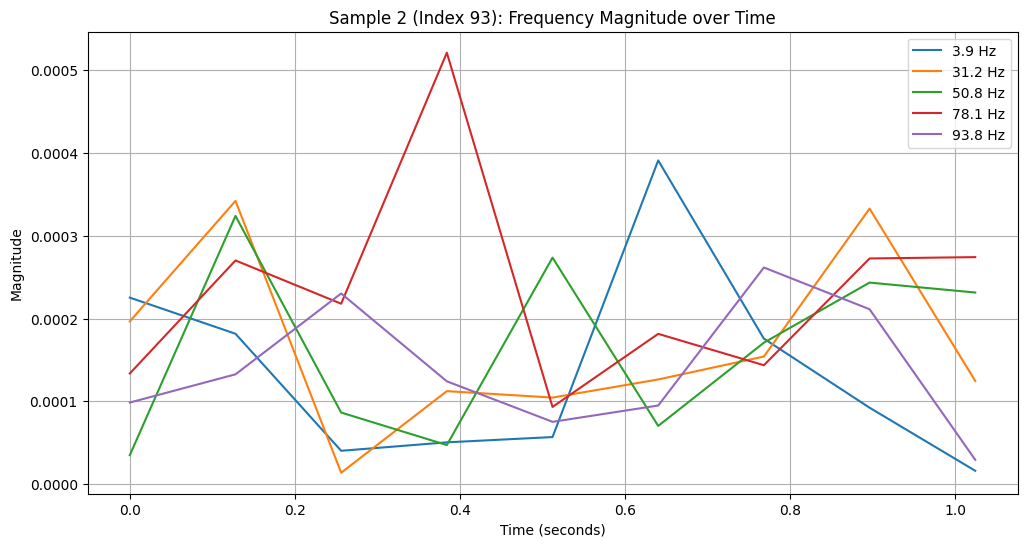

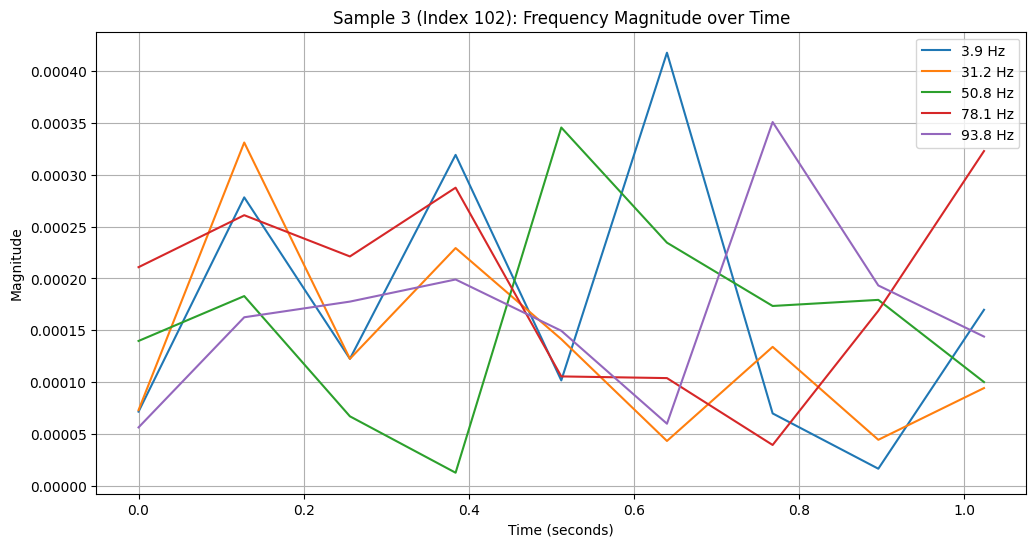

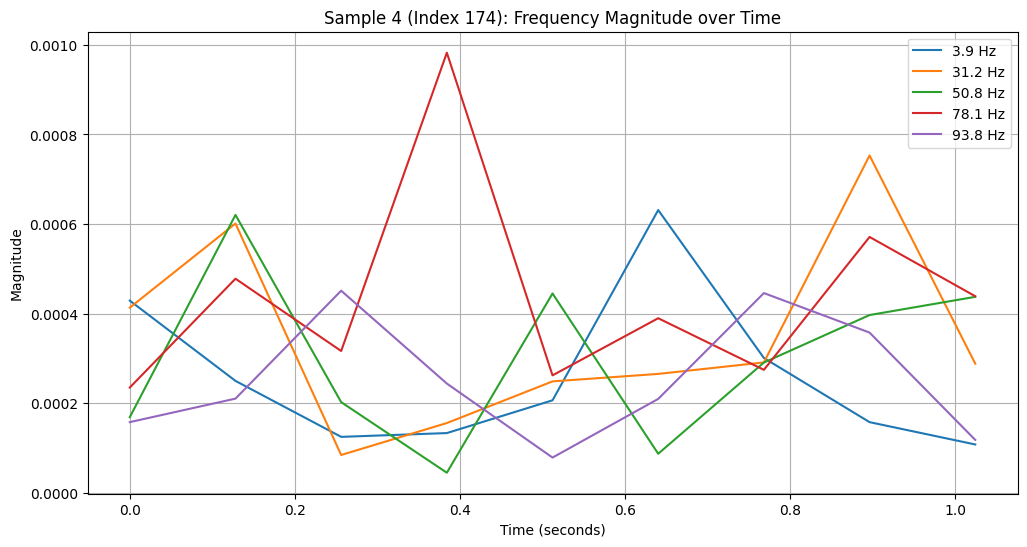

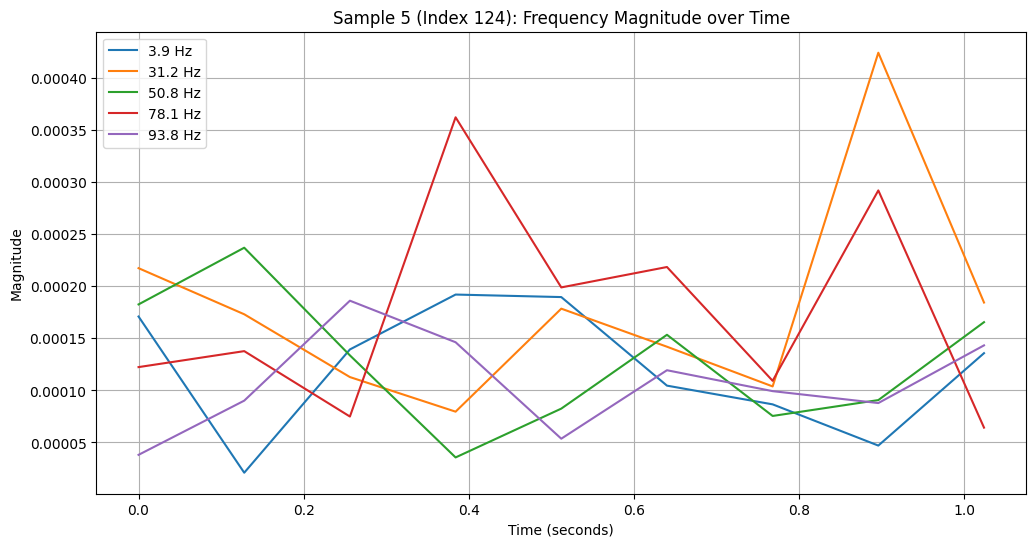

In [6]:
fs = 1000.0
num_samples = embedded_data.shape[0]

indices = np.random.choice(num_samples, 5, replace=False)

freqs_to_check = [5, 30, 50, 80, 95]

for i, idx in enumerate(indices, 1):
    signal = embedded_data[idx,0,0,:]
    
    f, t, Zxx = stft(signal, fs=fs, nperseg=256)
    magnitude = np.abs(Zxx)
    freqs_to_plot = [np.argmin(np.abs(f - freq)) for freq in freqs_to_check]

    plt.figure(figsize=(12, 6))
    for freq_idx in freqs_to_plot:
        plt.plot(t, magnitude[freq_idx, :], label=f'{f[freq_idx]:.1f} Hz')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Magnitude')
    plt.title(f'Sample {i} (Index {idx}): Frequency Magnitude over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
 
#picking 5 random samples and plotting magnitudes of various frequencies over time
#the graph of whatever frequency peaks during a particular time period means that frequency is dominant